# Домашнее задание №4
*Задание выполнил* **Чащин Артем Максимович**

*Курс:* **3**, *группа:* **МФТИ-1**

**[GitHub](https://github.com/alexvilno/PSU_TIMESERIES/tree/HW2)**

**[Telegram](https://t.me/artemchashchin)**

## Оглавление
* [Импорт данных](#import)
* [Описание всех функций, которые мне нужны](#func)
    * [split_dataframe](#split_dataframe)
    * [get_arima_pred_list](#get_arima_pred_list)
    * [view_forecast_plot_with_pred](#view_forecast_plot_with_pred)
    * [print_metrics](#print_metrics)
    * [самая важная функция, которой я пользуюсь в жизни](#joke)
* [Предсказание с помощью ARMA и ARIMA](#arma)
* [Оценка метрик](#benchmark)
* [Делаем пропуски](#misses)
* [Убираем пропуски](#rmisses)
* [Ищем выбросы](#dec)
* [Убираем выбросы](#rdec)



### Импорт <a id="import"></a>

In [424]:
import os
import pandas as pd
import numpy as np

from os import path
from matplotlib import pyplot as plt
from dotenv import load_dotenv

In [425]:
load_dotenv(dotenv_path='../.env')

True

Импортируем данныe

In [426]:
file_path = os.getenv('PATH_TO_DATA')

sales_df = pd.read_csv(
    path.join(os.sep, file_path, 'data.csv'),
    names=["t","x"], skiprows=1
)

Функция, которая добавляет легенду на график

In [427]:
def plot_assignation(
        axp: plt.Axes, 
        data: np.ndarray, 
        xlabel: str, 
        ylabel: str, 
        title1: str, 
        periods: int
) -> None:
    axp.plot(data)
    axp.set_xlabel(xlabel)
    axp.set_ylabel(ylabel)
    axp.set_title(title1)
    axp.set_xticks(np.arange(0, len(sales_df['x']) + 1, 12))
    axp.set_xticklabels(np.arange(periods + 1))

В соответсвтии с моими данными я визуализирую выборку на графике и добавляю его легенду

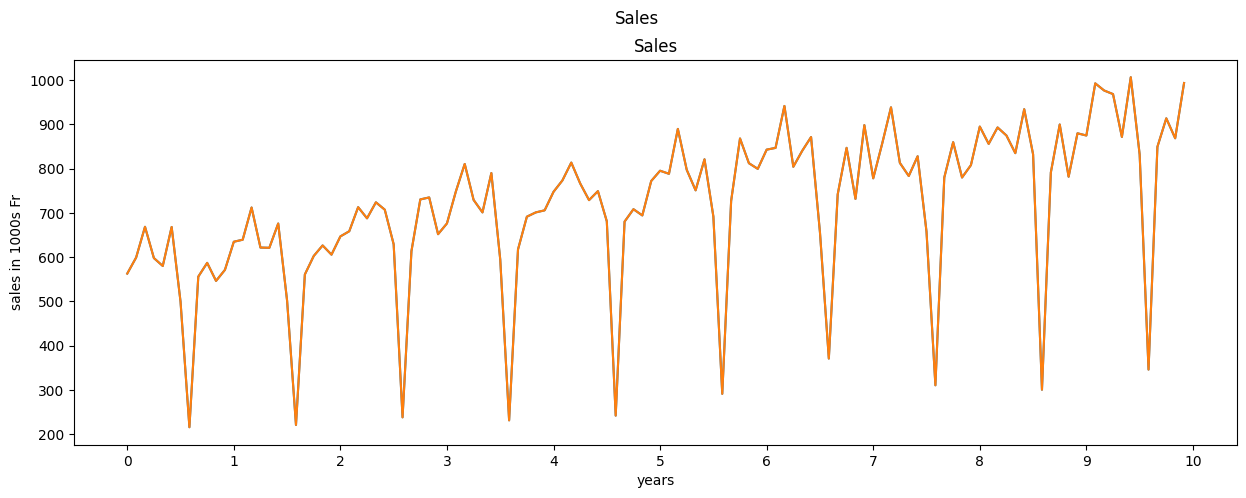

In [428]:
#выборка по 10 годам
period = 10

fig, axs = plt.subplots(1,1,figsize=(15,5))
fig.suptitle('Sales')
plot_assignation(
    axp=axs, 
    data=sales_df["x"], 
    xlabel="years",
    ylabel="sales in 1000s Fr",
    title1="Sales", 
    periods=period
)
axs.plot(sales_df['x'])

### Описание всех функций, которые мне нужны <a id="func"></a>

#### split_dataframe <a id="split_dataframe"> </a>

Эта функция разбивает датафрейм на необходимое число датафреймов по заданным процентным соотношениям каждого разбиения *(ratios)*.
Т.е. например если нам нужно разбить датафрейм на три части в процентном соотношении *30%, 25%, 45%*, то нужно передать в ratios=[0.3, 0.25, 0.45] *(len(ratios) равна количеству получаемых датафреймов, сумма ratios должна быть равна 1)*

In [429]:
from typing import Optional

def split_dataframe(
    df: pd.DataFrame, 
    ratios: list[float],
    time_index: str
) -> Optional[list[pd.DataFrame]]:
    """
    num_partitions - количество разбиений, на который необходимо разбить датафрейм
    ratios - позиционный список процентных соотношений разбиений, значения - 
    часть от общего количества наблюдений в датафрейме
    """

    if sum(ratios) != 1 and ratios:
        raise ValueError("Сумма ratios не равна 1")
    
    partitions = []
    cutoffs = [int(round(len(df) * ratio, 0)) for ratio in ratios]

    for i in range(len(ratios)):
        if i == 0:
            lower_bound = 0
        else:
            lower_bound = sum(cutoffs[:i])

        upper_bound = sum(cutoffs[:i + 1])

        partition = df[(df[time_index] > lower_bound) & (df[time_index] <= upper_bound)]
        partitions.append(partition)

    return partitions

#### get_arima_pred_list <a id="get_arima_pred_list"> </a>

Функция используется для получения списка предсказаний, сделанных с помощью модели **ARIMA**. Длина возвращаемого списка равна длине test.

In [430]:
from typing import Union, List

def get_arima_pred_list(
    p: Union[List[int], int], 
    d: int, 
    q: Union[List[int], int],
    train: pd.DataFrame,
    test: pd.DataFrame,
    data_index: str
) -> list:
    """
    p - число наблюдений лагов в модели
    d - степень дифференцируемости
    q - скользящее среднее
    train - обучающая выборка
    test - тестовая выборка
    target_index - индекс target столбца в датафрейме
    """
    history = [x for x in train[data_index]]

    arma_pred = list()

    for t in range(len(train + 1),len(test) + len(train)):
        model = ARIMA(history, order=(p,d,q))
        model_fit = model.fit()
        out = model_fit.forecast()
        yhat = out[0]
        obs = test[data_index][t]
        arma_pred.append(yhat)
        history.append(obs)

    return arma_pred

#### view_forecast_plot_with_pred <a id="view_forecast_plot_with_pred"> </a>

Функция отрисовывает график датафреймов, а также поверх этих датафреймов может отрисовать предсказания, если они переданы в функцию. Важно соблюдать позиционность передачи аргументов, т.е. если передать 

```dataframes=[df, df1, df2], predicted_data=[None, df1_pred ,None]``` 

то поверх df1 будет отрисовываться df1_pred при условии, что количество наблюдений одинаково. 

In [431]:
from typing import List, Optional

def view_forecast_plot_with_pred(
        dataframes: List[pd.DataFrame], 
        predicted_dataframes: Optional[List[pd.DataFrame]] = None
) -> None:
    """
    dataframes - список датафреймов для отрисовки на графике
    predicted_dataframes - список предсказаний отрисовывающихся поверх датафреймов
    """
    plt.figure(figsize=(15,5))
    
    for i, df in enumerate(dataframes):
        plt.plot(df.t, df.x, label=f'Partition {i+1}')

    for i, df in enumerate(predicted_dataframes):
        if df is not None:
            if len(dataframes[i]) != len(df):
                raise ValueError(f"Размерность датафрейма {i} не совпадает с размерностью его предсказаний")
            plt.plot(dataframes[i].t, df, label=f'Partition {i+1} predicted')

    plt.plot()
    plt.legend()
    plt.show()

#### print_metrics <a id="print_metrics"> </a>

Функция считает метрики *RMSE, MAPE, SMAPE, MAE, R2*

In [432]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

def SMAPE(forecast: pd.DataFrame, forecast_pred: pd.DataFrame) -> float:
    return np.sum((np.abs(forecast - forecast_pred)) / ((np.abs(forecast) + np.abs(forecast_pred)) / 2)) * 100 / len(forecast)

def print_metrics(true: pd.DataFrame, pred: list, target_index: str):
    print("RMSE:", np.sqrt(mean_squared_error(true[target_index], pred)))
    print("MAPE:", mean_absolute_percentage_error(true[target_index], pred))
    print("SMAPE:", SMAPE(true[target_index], pred))
    print("MAE:", mean_absolute_error(true[target_index], pred))
    print("R2: ", r2_score(true[target_index], pred))

#### самая важная функция, которой я пользуюсь в жизни <a id="joke"> </a>

In [433]:
def important_function(*args, **kwargs):
    pass

### Предсказание с помощью ARMA и ARIMA <a id="arma"></a>

/Users/alexvilno/Desktop/TIMESERIES/GIT_HOMEWORK/PSU_TIMESERIES/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alexvilno/Desktop/TIMESERIES/GIT_HOMEWORK/PSU_TIMESERIES/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/alexvilno/Desktop/TIMESERIES/GIT_HOMEWORK/PSU_TIMESERIES/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


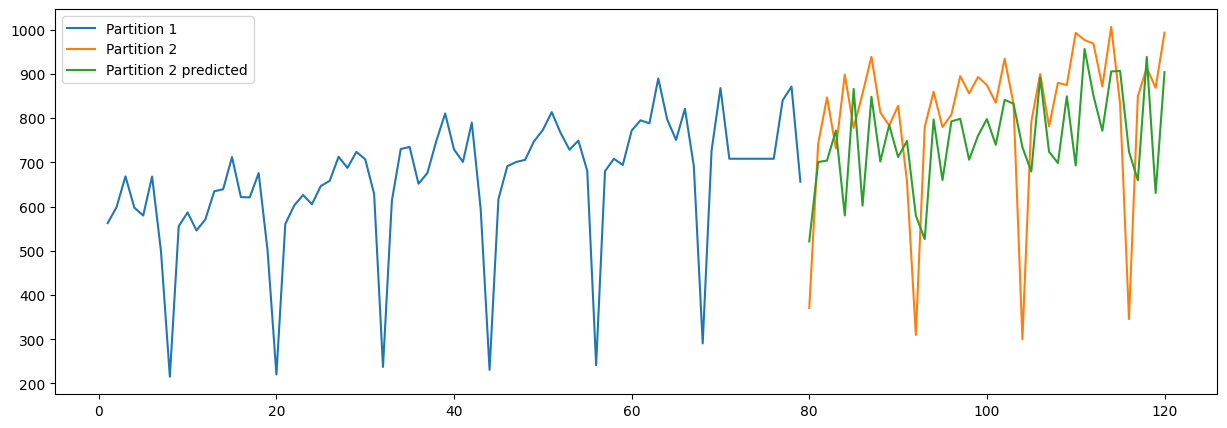

RMSE: 164.10846516215227
MAPE: 0.20745822269387265
SMAPE: 18.642368127036036
MAE: 128.40824372101102
R2:  0.09591211461011406


In [448]:
train, test = split_dataframe(sales_df, [0.66, 0.34], 't')
arma_pred = get_arima_pred_list(5, 0, 3, train, test, 'x')
view_forecast_plot_with_pred([train, test],[None, arma_pred])
print_metrics(test, arma_pred, 'x')
important_function()

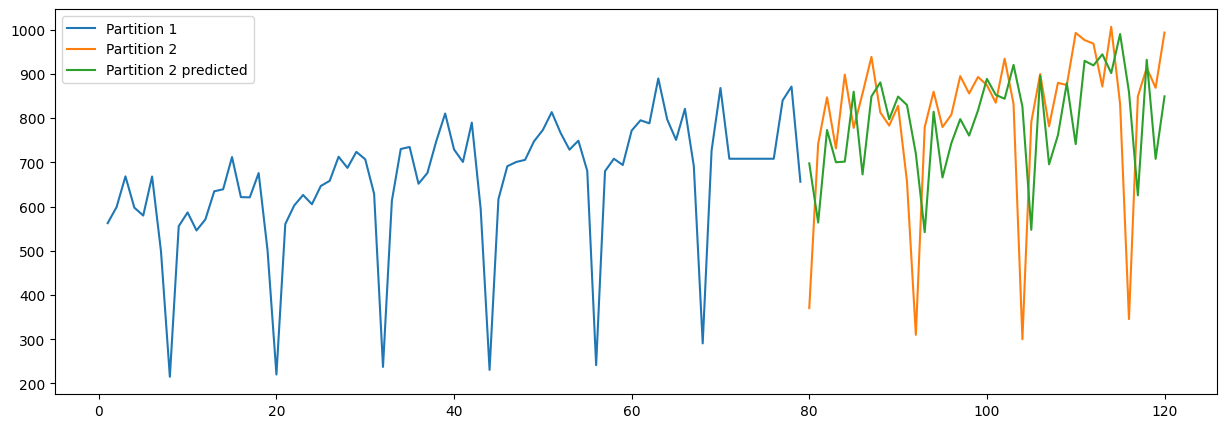

In [446]:
train, test = split_dataframe(sales_df, [0.66, 0.34], 't')
arima_pred = get_arima_pred_list(5, 1, 0, train, test, 'x')
view_forecast_plot_with_pred([train, test],[None, arima_pred])
important_function()

### Оценка метрик <a id="benchmark"> </a>

In [436]:
print("Оценка метрик для ARMA")
print_metrics(test, arma_pred, 'x')
print("Оценка метрик для ARIMA")
print_metrics(test, arima_pred, 'x')

Оценка метрик для ARMA
RMSE: 183.16929852549126
MAPE: 0.23653338383249542
SMAPE: 21.397460166162148
MAE: 148.76206690461382
R2:  -0.1262999032672225
Оценка метрик для ARIMA
RMSE: 214.18222932684571
MAPE: 0.2704066631497786
SMAPE: 25.839030668839115
MAE: 183.93528852866677
R2:  -0.5399816701996425


### Делаем пропуски <a id="misses"> </a>

/var/folders/ns/8k4fm20x1_g6s3_88nzjddf00000gn/T/ipykernel_41917/2656791271.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df['x'][70:75] = np.nan


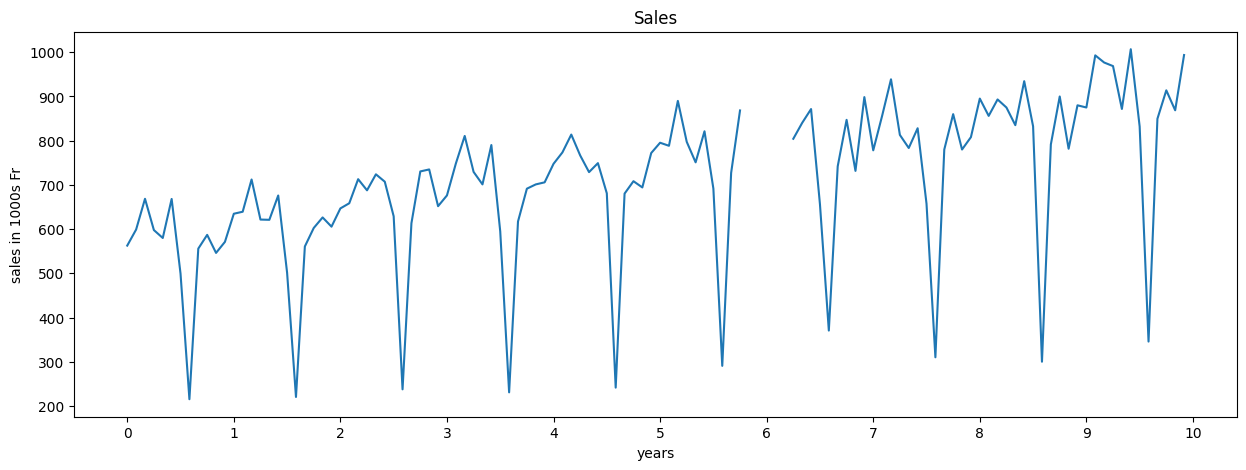

In [437]:
sales_df['x'][70:75] = np.nan

fig, axs = plt.subplots(1,1,figsize=(15,5))
plot_assignation(
    axp=axs, 
    data=sales_df["x"], 
    xlabel="years",
    ylabel="sales in 1000s Fr",
    title1="Sales", 
    periods=period
)

### Убираем пропуски <a id="rmisses"> </a>

Заполнение средним значением следующего и предыдущего

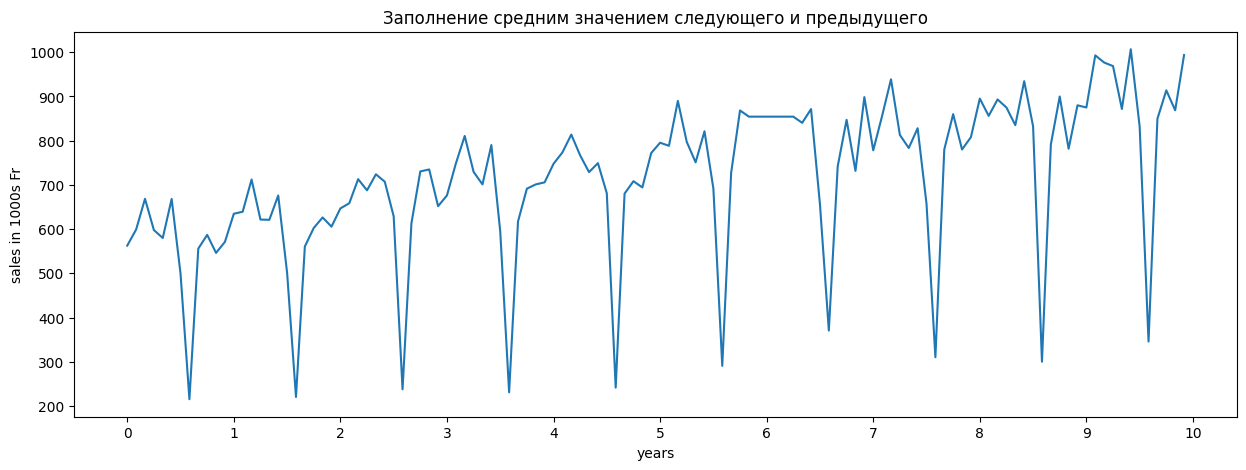

In [438]:
sales_df.loc[70:75, 'x'] = (sales_df.loc[69, 'x'] + sales_df.loc[76, 'x']) / 2

fig, axs = plt.subplots(1,1,figsize=(15,5))
plot_assignation(
    axp=axs, 
    data=sales_df["x"], 
    xlabel="years",
    ylabel="sales in 1000s Fr",
    title1="Заполнение средним значением следующего и предыдущего", 
    periods=period
)

Заполнение значением следующего

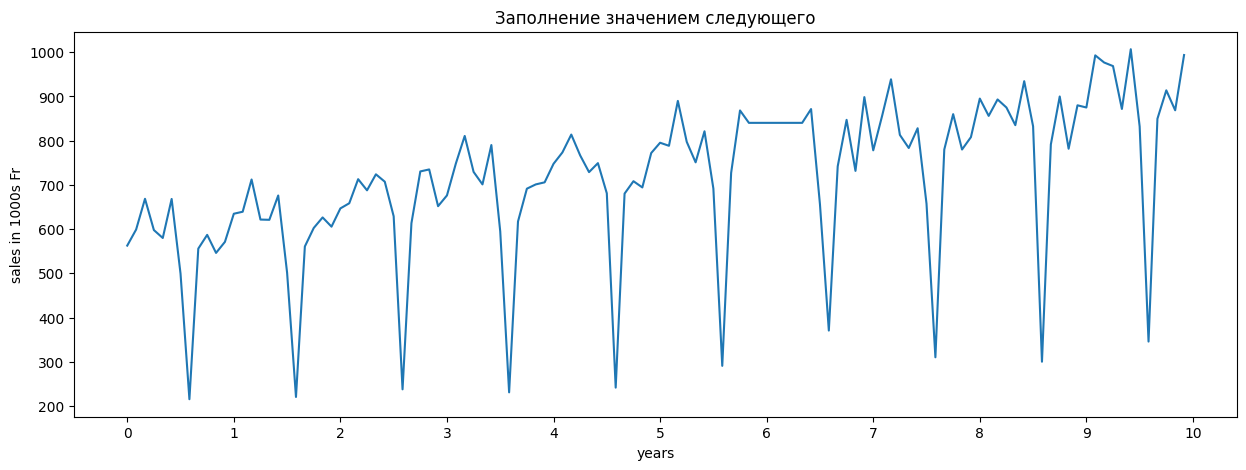

In [439]:
sales_df.loc[70:75, 'x'] = sales_df.loc[76, 'x']

fig, axs = plt.subplots(1,1,figsize=(15,5))
plot_assignation(
    axp=axs, 
    data=sales_df["x"], 
    xlabel="years",
    ylabel="sales in 1000s Fr",
    title1="Заполнение значением следующего", 
    periods=period
)

Заполнение медианой

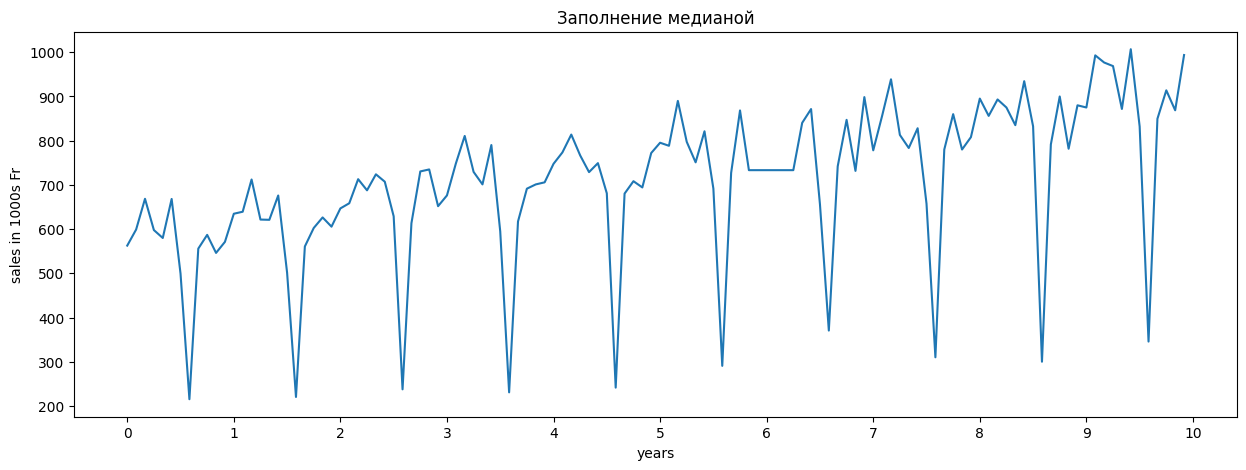

In [440]:
sales_df.loc[70:75, 'x'] = sales_df['x'].median()

fig, axs = plt.subplots(1,1,figsize=(15,5))
plot_assignation(
    axp=axs, 
    data=sales_df["x"], 
    xlabel="years",
    ylabel="sales in 1000s Fr",
    title1="Заполнение медианой", 
    periods=period
)

Заполнение средним значением

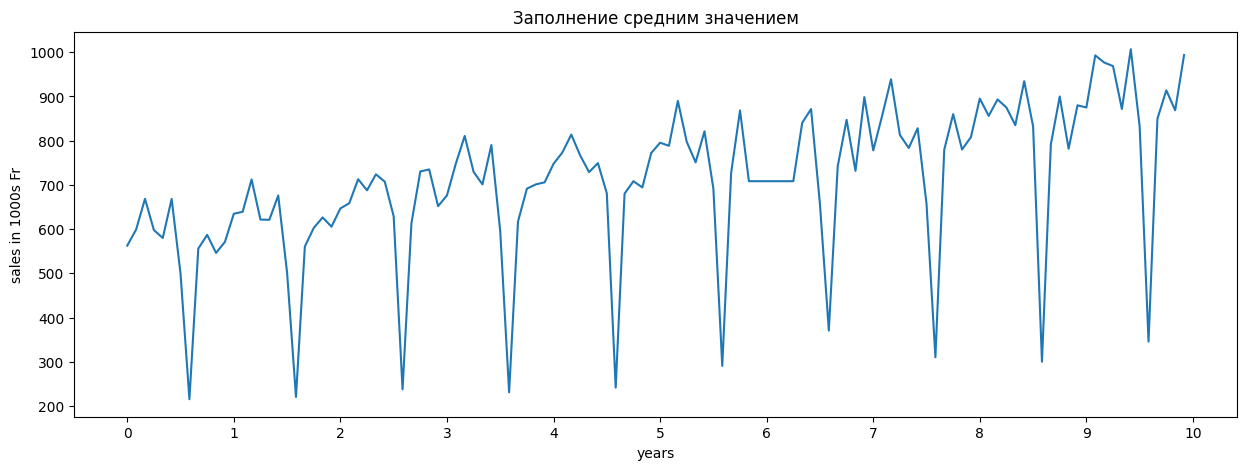

In [441]:
sales_df.loc[70:75, 'x'] = sales_df['x'].mean()

fig, axs = plt.subplots(1,1,figsize=(15,5))
plot_assignation(
    axp=axs, 
    data=sales_df["x"], 
    xlabel="years",
    ylabel="sales in 1000s Fr",
    title1="Заполнение средним значением", 
    periods=period
)

### Ищем выбросы <a id="dec"> </a>

Эта функция ищет выбросы и подсвечивает их на графике

120


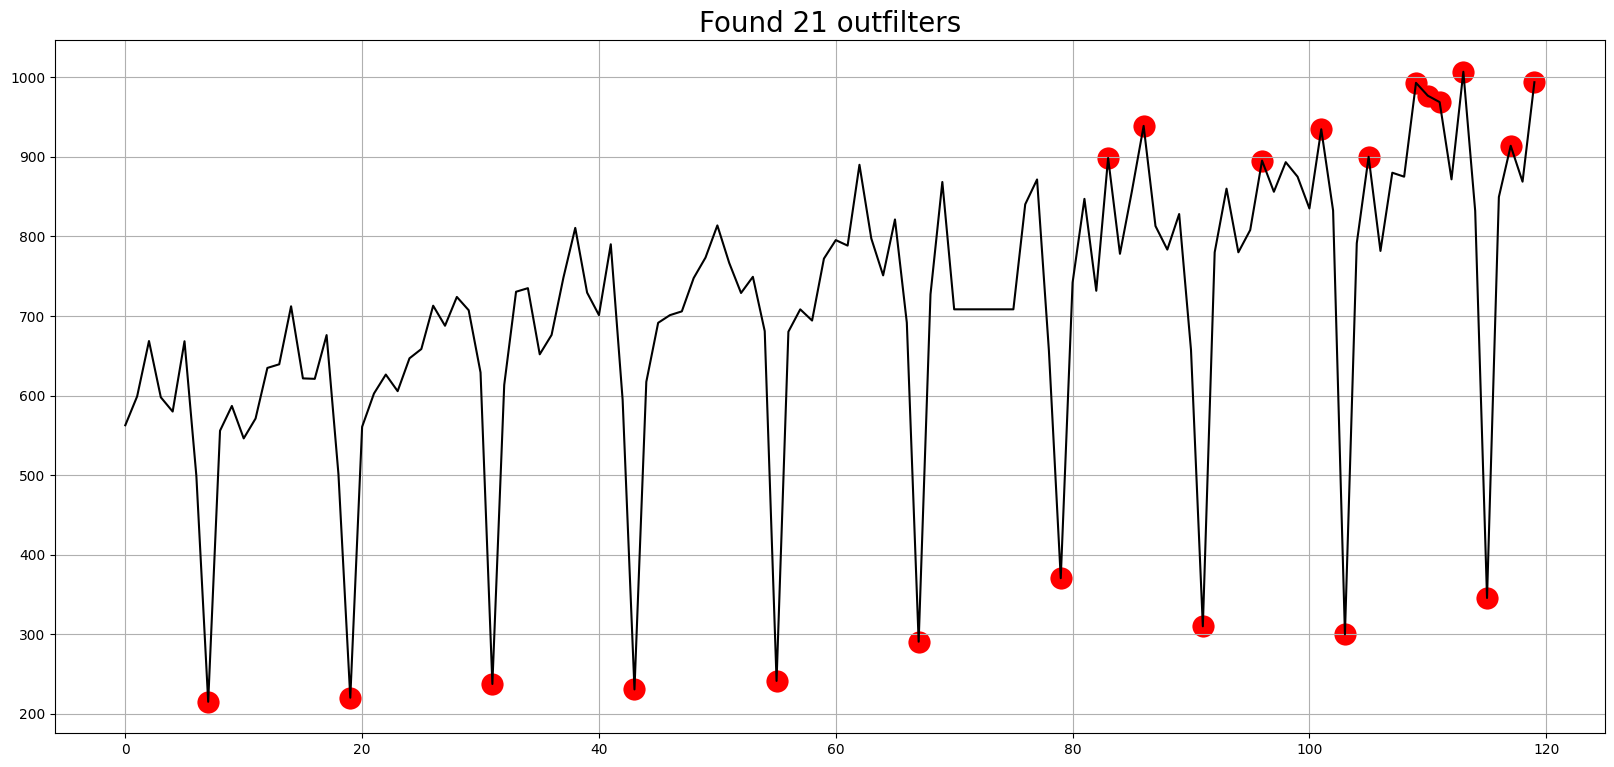

In [442]:
import seaborn as sns
from sklearn import preprocessing, svm

def show_found_outliers(
    dataframe: pd.DataFrame,
    target_index: str,
    perc: Optional[float] = 0.17
) -> None:
    scaler = preprocessing.StandardScaler()
    ts_scaled = scaler.fit_transform(dataframe[target_index].values.reshape(-1, 1))
    print(len(ts_scaled))
    model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
    model.fit(ts_scaled)
    
    df_outfilers = dataframe[target_index].to_frame(name="ts")
    df_outfilers["index"] = range(len(dataframe))
    df_outfilers["outlier"] = model.predict(ts_scaled)
    df_outfilers["outlier"] = df_outfilers["outlier"].apply(lambda x: 1 if x == -1 else 0)

    fig, ax = plt.subplots(figsize=(20, 9))
    ax.plot(df_outfilers["index"], df_outfilers["ts"], color="black")
    ax.scatter(
        x=df_outfilers[df_outfilers["outlier"] == 1]["index"],
        y=df_outfilers[df_outfilers["outlier"] == 1]["ts"],
        color="red",
        linewidths=10
    )
    plt.title(f"Found {sum(df_outfilers['outlier'] == 1)} outfilters", fontdict={'fontsize': 20})
    ax.grid(True)
    plt.show()


show_found_outliers(
    dataframe=sales_df,
    target_index='x',
    perc=0.18
)

### Убираем выбросы <a id="rdec"> </a>

Я решил, что для удаления выбросов я буду использовать линейную интерполяцию

In [443]:
def remove_outliers(
    dataframe: pd.DataFrame,
    target_index: str,
    perc: Optional[float] = 0.1
) -> pd.DataFrame:
    scaler = preprocessing.StandardScaler()
    ts_scaled = scaler.fit_transform(dataframe[target_index].values.reshape(-1, 1))
    print(len(ts_scaled))
    model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
    model.fit(ts_scaled)
    
    df_outfilers = dataframe[target_index].to_frame(name="ts")
    df_outfilers["index"] = range(len(dataframe))
    df_outfilers["outlier"] = model.predict(ts_scaled)
    df_outfilers["outlier"] = df_outfilers["outlier"].apply(lambda x: 1 if x == -1 else 0)

    dataframe_clean = dataframe.copy()
    dataframe_clean.loc[df_outfilers[df_outfilers["outlier"] == 1].index] = np.nan
    
    return dataframe_clean

Удаление выбросов:

120


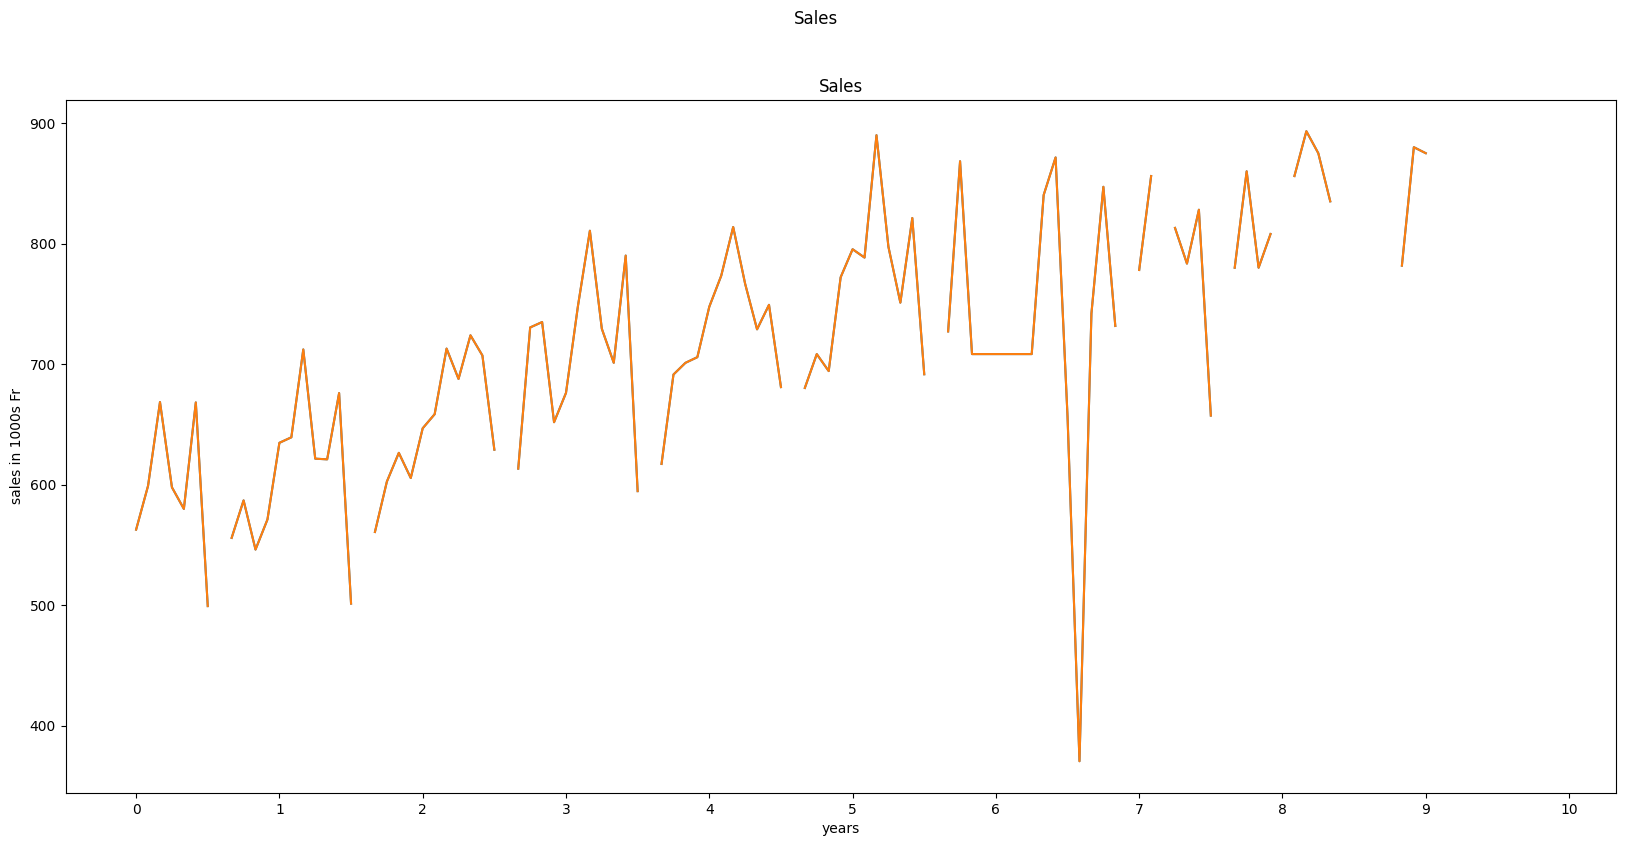

In [444]:
sales_clean = remove_outliers(
    dataframe=sales_df,
    target_index='x',
    perc=0.17
)

fig, axs = plt.subplots(1,1,figsize=(20,9))
fig.suptitle('Sales')
plot_assignation(
    axp=axs, 
    data=sales_clean["x"], 
    xlabel="years",
    ylabel="sales in 1000s Fr",
    title1="Sales", 
    periods=period
)
axs.plot(sales_clean['x'])

С помощью линейной интерполяции получим такой результат

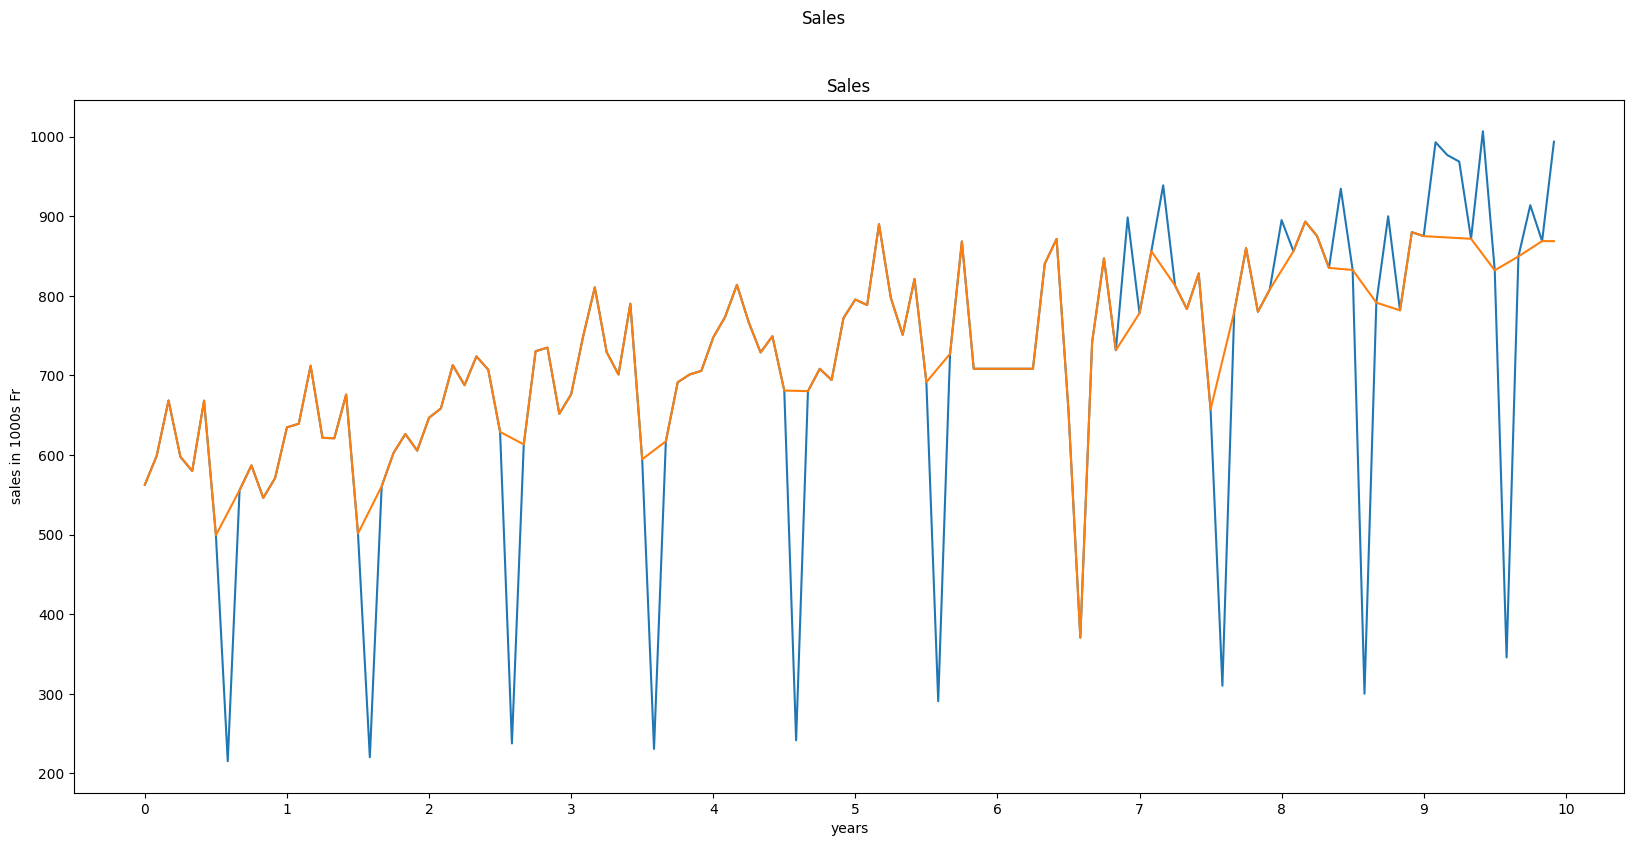

In [450]:
sales_clean = sales_clean.interpolate(method="linear")
fig, axs = plt.subplots(1,1,figsize=(20,9))
fig.suptitle('Sales')
axs.plot(sales_df['x'])
plot_assignation(
    axp=axs, 
    data=sales_clean["x"], 
    xlabel="years",
    ylabel="sales in 1000s Fr",
    title1="Sales", 
    periods=period
)
